### Análise Territorial da Inadimplência — Paraisópolis

Este notebook documenta passo a passo a análise de dados realizada para compreender
o comportamento de pagamento, consumo e relacionamento dos clientes da Sabesp
no território de Paraisópolis.

O foco da análise é o **setor censitário**, permitindo identificar padrões territoriais
e apoiar a definição de estratégias diferenciadas para redução da inadimplência.

O notebook foi estruturado de forma didática, com explicações em cada etapa,
permitindo reprodutibilidade e transparência metodológica.


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


#### Leitura das bases de dados

Nesta etapa, carregamos as duas bases utilizadas no projeto:

- **Base operacional (água e esgoto)**: contém informações de clientes, fornecimentos, consumo, inadimplência,
  irregularidades e características do imóvel.
- **Base do IBGE**: contém indicadores demográficos, habitacionais e educacionais no nível de setor censitário.

As bases serão integradas posteriormente por meio do código do setor censitário (`CD_SETOR`).


In [68]:
df_operacional = pd.read_excel("RESULTADO_LIG_PARAISOPOLIS_20260105.xlsx")
df_ibge = pd.read_excel("Paraisópolis.xlsx")


#### Base operacional: visão geral

A base operacional reúne informações de clientes atendidos no território de Paraisópolis,
incluindo dados de localização territorial, consumo, inadimplência, irregularidades
e características do atendimento.

Cada linha da base representa um **registro associado a um cliente (PDE) em um endereço**,
localizado em um determinado **setor censitário (CD_SETOR)**.

Nesta etapa, fazemos apenas uma checagem estrutural da base, sem transformar os dados.


In [69]:
df_operacional.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12540 entries, 0 to 12539
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PDE                      12540 non-null  int64         
 1   ID_FORNECIMENTO          12540 non-null  int64         
 2   NOME_SA_AC               12540 non-null  object        
 3   NOME_BE_AC               12540 non-null  object        
 4   CODIGO_IBG               12540 non-null  int64         
 5   CD_SETOR                 12540 non-null  int64         
 6   CD_SUPERIN               12540 non-null  int64         
 7   DATA_LIGAC               12539 non-null  datetime64[ns]
 8   DATA_LIG_1               11783 non-null  datetime64[ns]
 9   DS_ENT_ORG               12540 non-null  object        
 10  NR_ECON_IND              11618 non-null  float64       
 11  NR_ECON_RES              11618 non-null  float64       
 12  NR_ECON_PUB              11618 n

In [70]:
df_operacional.columns.tolist()

['PDE',
 'ID_FORNECIMENTO',
 'NOME_SA_AC',
 'NOME_BE_AC',
 'CODIGO_IBG',
 'CD_SETOR',
 'CD_SUPERIN',
 'DATA_LIGAC',
 'DATA_LIG_1',
 'DS_ENT_ORG',
 'NR_ECON_IND',
 'NR_ECON_RES',
 'NR_ECON_PUB',
 'NR_FATOR_K',
 'MUNICIPIO',
 'NOME_BACIA',
 'NOME_SETOR',
 'RECORTE',
 'SIGLA_BACI',
 'SIGLA_SETO',
 'SITUACAO_FORNECIMENTO',
 'SITUACAO_A',
 'SITUACAO_E',
 'TL',
 'TRAT_ESG_D',
 'DS_TP_UTILIZACAO',
 'QTD_DEBITOS_ABERTOS',
 'VALOR_TOTAL_ABERTO',
 'FLAG_MIG_GEN',
 'TIPO_IMOVEL',
 'PERFIL_TARIFARIO',
 'ENQUADRA_TARIFA_SOCIAL',
 'ENDERECO_COMPLETO',
 'LATITUDE',
 'LONGITUDE',
 'DATA_LIGACAO_AGUA',
 'QTD_IRREGULARIDADES',
 'MEDIA_CONSUMO_12_MESES',
 'MEDIA_CONSUMO_24_MESES',
 'VEZES_ACIMA_DOBRO_MEDIA',
 'TEM_DEBITO']

#### Unidade de análise adotada no projeto

Para garantir consistência analítica, o projeto trabalha com três níveis de observação bem definidos:

- **Cliente**: identificado pelo campo `PDE`, representando um indivíduo cadastrado.
- **Imóvel (proxy)**: representado pelo campo `ENDERECO_COMPLETO`, utilizado como referência física do atendimento.
- **Território**: definido pelo setor censitário (`CD_SETOR`), que constitui a principal unidade territorial de análise.

As análises de inadimplência, consumo, irregularidades e perfil tarifário são inicialmente realizadas no nível de cliente/imóvel
e posteriormente agregadas no nível territorial, permitindo uma leitura consolidada do comportamento dos setores censitários.


In [71]:
# Garantir que colunas numéricas estejam no formato correto
colunas_numericas = [
    "NR_ECON_IND", "NR_ECON_RES", "NR_ECON_PUB",
    "QTD_DEBITOS_ABERTOS", "VALOR_TOTAL_ABERTO",
    "QTD_IRREGULARIDADES",
    "MEDIA_CONSUMO_12_MESES", "MEDIA_CONSUMO_24_MESES",
    "TL"
]

for col in colunas_numericas:
    if col in df_operacional.columns:
        df_operacional[col] = pd.to_numeric(df_operacional[col], errors="coerce")

In [72]:
# Para variáveis de contagem/valor, ausência é interpretada como zero
cols_zero = [
    "NR_ECON_IND", "NR_ECON_RES", "NR_ECON_PUB",
    "QTD_DEBITOS_ABERTOS", "VALOR_TOTAL_ABERTO",
    "QTD_IRREGULARIDADES"
]

for col in cols_zero:
    if col in df_operacional.columns:
        df_operacional[col] = df_operacional[col].fillna(0)

# Para consumo, mantemos 0 apenas para ausência explícita
df_operacional["MEDIA_CONSUMO_12_MESES"] = df_operacional["MEDIA_CONSUMO_12_MESES"].fillna(0)
df_operacional["MEDIA_CONSUMO_24_MESES"] = df_operacional["MEDIA_CONSUMO_24_MESES"].fillna(0)

In [73]:
# Criação das variáveis analíticas principais

# 1) Escala do cliente: total de economias
df_operacional["TOTAL_ECONOMIAS"] = (
    df_operacional["NR_ECON_IND"] +
    df_operacional["NR_ECON_RES"] +
    df_operacional["NR_ECON_PUB"]
)

# 2) Perfil de pagamento: indicador de inadimplência
df_operacional["TEM_DEBITO"] = (df_operacional["QTD_DEBITOS_ABERTOS"] > 0).astype(int)

# 3) Tipo de ligação: água (0) ou água + esgoto (1)
df_operacional["LIGACAO_AGUA_ESGOTO"] = (df_operacional["TL"] == 1).astype(int)

# 4) Perfil de irregularidades
df_operacional["TEM_IRREGULARIDADE"] = (df_operacional["QTD_IRREGULARIDADES"] > 0).astype(int)


In [74]:
df_operacional[[
    "PDE", "CD_SETOR", "ENDERECO_COMPLETO",
    "TOTAL_ECONOMIAS",
    "TEM_DEBITO", "QTD_DEBITOS_ABERTOS", "VALOR_TOTAL_ABERTO",
    "TL", "LIGACAO_AGUA_ESGOTO",
    "QTD_IRREGULARIDADES", "TEM_IRREGULARIDADE",
    "MEDIA_CONSUMO_12_MESES", "MEDIA_CONSUMO_24_MESES",
    "PERFIL_TARIFARIO", "ENQUADRA_TARIFA_SOCIAL", "TIPO_IMOVEL"
]].head(5)

,PDE,CD_SETOR,ENDERECO_COMPLETO,TOTAL_ECONOMIAS,TEM_DEBITO,QTD_DEBITOS_ABERTOS,VALOR_TOTAL_ABERTO,TL,LIGACAO_AGUA_ESGOTO,QTD_IRREGULARIDADES,TEM_IRREGULARIDADE,MEDIA_CONSUMO_12_MESES,MEDIA_CONSUMO_24_MESES,PERFIL_TARIFARIO,ENQUADRA_TARIFA_SOCIAL,TIPO_IMOVEL
0,194075303,355030883000040,"RUA DOUTOR FRANCISCO THOMAZ CARVALHO, 442",1.0,1,1.0,89.52,1,1,0,0,20.769231,20.360000,SOCIAL - 50% DA TARIFA RESIDENCIAL,SIM,RESIDENCIAL
1,194082776,355030883000363,"RUA AFONSO DE OLIVEIRA SANTOS, 300",1.0,1,4.0,11380.14,1,1,0,0,0.000000,0.000000,SOCIAL,SIM,RESIDENCIAL
2,194082857,355030883000363,"RUA AFONSO DE OLIVEIRA SANTOS, 82",1.0,1,4.0,86.52,1,1,0,0,1.166667,1.750000,SOCIAL,SIM,RESIDENCIAL
3,194082938,355030883000363,"RUA AFONSO DE OLIVEIRA SANTOS, 92",1.0,1,22.0,537.61,1,1,0,0,0.833333,1.333333,SOCIAL - TRANSIÇÃO,SIM,RESIDENCIAL
4,194083152,355030883000363,"RUA RUDOLF LOTZE, 1341",0.0,0,0.0,0.00,1,1,1,1,0.000000,0.000000,NaN,SIM,NaN


In [75]:
# Checagens rápidas de consistência
print("Linhas:", len(df_operacional))
print("Clientes (PDE) únicos:", df_operacional["PDE"].nunique())
print("Setores (CD_SETOR) únicos:", df_operacional["CD_SETOR"].nunique())

print("\n% com débito (linha):", df_operacional["TEM_DEBITO"].mean())
print("% com irregularidade (linha):", df_operacional["TEM_IRREGULARIDADE"].mean())
print("\nTOTAL_ECONOMIAS (min/med/max):",
      df_operacional["TOTAL_ECONOMIAS"].min(),
      df_operacional["TOTAL_ECONOMIAS"].median(),
      df_operacional["TOTAL_ECONOMIAS"].max())


Linhas: 12540
Clientes (PDE) únicos: 12540
Setores (CD_SETOR) únicos: 85

% com débito (linha): 0.7766347687400319
% com irregularidade (linha): 0.1862041467304625

TOTAL_ECONOMIAS (min/med/max): 0.0 1.0 260.0


In [76]:
# Agregação por setor censitário (CD_SETOR)


df_setor = (
    df_operacional
    .groupby("CD_SETOR")
    .agg(
        # Escala
        total_clientes=("PDE", "nunique"),
        total_enderecos=("ENDERECO_COMPLETO", "nunique"),
        total_economias=("TOTAL_ECONOMIAS", "sum"),

        # Pagamento
        clientes_com_debito=("TEM_DEBITO", "sum"),
        valor_total_aberto=("VALOR_TOTAL_ABERTO", "sum"),

        # Irregularidades
        clientes_com_irregularidade=("TEM_IRREGULARIDADE", "sum"),
        total_irregularidades=("QTD_IRREGULARIDADES", "sum"),

        # Consumo 
        consumo_medio_12m=("MEDIA_CONSUMO_12_MESES", "mean"),
        consumo_medio_24m=("MEDIA_CONSUMO_24_MESES", "mean"),

        # Serviço
        pct_ligacao_agua_esgoto=("LIGACAO_AGUA_ESGOTO", "mean")
    )
    .reset_index()
)


In [77]:
# KPIs territoriais

# Intensidade da inadimplência
df_setor["pct_clientes_com_debito"] = (
    df_setor["clientes_com_debito"] / df_setor["total_clientes"]
)

# Intensidade de irregularidades
df_setor["pct_clientes_com_irregularidade"] = (
    df_setor["clientes_com_irregularidade"] / df_setor["total_clientes"]
)

# Impacto financeiro médio
df_setor["valor_medio_aberto_por_cliente_inadimplente"] = np.where(
    df_setor["clientes_com_debito"] > 0,
    df_setor["valor_total_aberto"] / df_setor["clientes_com_debito"],
    0
)

# Escala média
df_setor["economias_por_cliente"] = (
    df_setor["total_economias"] / df_setor["total_clientes"]
)


In [78]:
# Checagem dos KPIs territoriais

df_setor[[
    "CD_SETOR",
    "total_clientes",
    "pct_clientes_com_debito",
    "valor_medio_aberto_por_cliente_inadimplente",
    "pct_clientes_com_irregularidade",
    "economias_por_cliente",
    "consumo_medio_12m",
    "consumo_medio_24m",
    "pct_ligacao_agua_esgoto"
]].head()


,CD_SETOR,total_clientes,pct_clientes_com_debito,valor_medio_aberto_por_cliente_inadimplente,pct_clientes_com_irregularidade,economias_por_cliente,consumo_medio_12m,consumo_medio_24m,pct_ligacao_agua_esgoto
0,355030883000009,58,0.810345,5625.966383,0.603448,0.931034,16.793251,14.583653,1.000000
1,355030883000015,153,0.718954,3098.812727,0.045752,0.915033,28.372891,26.048646,1.000000
2,355030883000040,173,0.826590,5100.098531,0.040462,0.930636,19.703207,19.917702,0.901734
3,355030883000072,74,0.554054,8213.702439,0.135135,0.837838,21.660123,23.208049,0.972973
4,355030883000076,62,0.403226,2543.080400,0.258065,0.838710,17.814379,14.555026,0.661290


In [79]:
# Resumo estatístico dos principais KPIs
df_setor[[
    "pct_clientes_com_debito",
    "pct_clientes_com_irregularidade",
    "valor_medio_aberto_por_cliente_inadimplente",
    "economias_por_cliente",
    "consumo_medio_12m",
    "consumo_medio_24m",
    "pct_ligacao_agua_esgoto"
]].describe()


,pct_clientes_com_debito,pct_clientes_com_irregularidade,valor_medio_aberto_por_cliente_inadimplente,economias_por_cliente,consumo_medio_12m,consumo_medio_24m,pct_ligacao_agua_esgoto
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.724723,0.185999,4738.177311,0.992043,21.952175,20.410928,0.922034
std,0.183514,0.168522,3805.664323,0.413854,15.829324,11.920886,0.157052
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.549908,0.166667
25%,0.672727,0.072607,3563.290292,0.915033,14.116367,14.517396,0.920152
50%,0.762712,0.147887,4233.647333,0.955307,18.748257,18.209541,0.993827
75%,0.830645,0.270370,5078.447313,0.983333,25.160034,23.208049,1.000000
max,1.000000,1.000000,34750.110000,4.094340,116.836777,73.031393,1.000000


#### Base IBGE: visão geral

A base do IBGE contém informações demográficas, habitacionais e educacionais
no nível do setor censitário.

Esses indicadores permitem contextualizar socialmente os setores analisados,
complementando a leitura operacional (inadimplência, consumo e irregularidades).

A integração com a base operacional será feita por meio do código do setor censitário (`CD_SETOR`).


In [80]:
df_ibge.head()

,id,CD_SETOR,SITUACAO,CD_SIT,CD_TIPO,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,...,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39,Alfabetização 40 a 44,Alfabetização 45 a 49,Alfabetização 50 a 54,Alfabetização 55 a 59,Alfabetização 60 a 64,Alfabetização 65 a 69,Alfabetização 70 a 80
0,90764,355030883000009,Urbana,1,1,0.016495,3,Sudeste,35,São Paulo,...,89.0,66.0,81.0,63.0,46.0,34.0,18.0,5.0,7.0,14.0
1,90894,355030883000210,Urbana,1,1,0.013716,3,Sudeste,35,São Paulo,...,105.0,120.0,106.0,123.0,54.0,74.0,32.0,16.0,9.0,28.0
2,90899,355030883000219,Urbana,1,1,0.009490,3,Sudeste,35,São Paulo,...,92.0,67.0,65.0,61.0,50.0,28.0,22.0,5.0,4.0,11.0
3,91019,355030883000346,Urbana,1,1,0.014818,3,Sudeste,35,São Paulo,...,114.0,126.0,89.0,236.0,119.0,109.0,44.0,11.0,7.0,34.0
4,91068,355030883000396,Urbana,1,1,0.005836,3,Sudeste,35,São Paulo,...,40.0,36.0,46.0,53.0,36.0,47.0,28.0,19.0,7.0,23.0


In [81]:
df_ibge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 45 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   id                                                       76 non-null     int64  
 1   CD_SETOR                                                 76 non-null     int64  
 2   SITUACAO                                                 76 non-null     object 
 3   CD_SIT                                                   76 non-null     int64  
 4   CD_TIPO                                                  76 non-null     int64  
 5   AREA_KM2                                                 76 non-null     float64
 6   CD_REGIAO                                                76 non-null     int64  
 7   NM_REGIAO                                                76 non-null     object 
 8   CD_UF                           

In [82]:
df_ibge.columns = df_ibge.columns.str.strip()

In [83]:
# Seleção das variáveis relevantes do IBGE

cols_ibge = [
    "CD_SETOR",
    "AREA_KM2",
    "Quantidade de pessoas",
    "Total de domicílios",
    "Total de domicílios particulares",
    "Total de domicílios particulares ocupados",
    "Média de moradores em domicílios particulares ocupados",
    "Acesso a água",
    "Acesso a esgoto",
    "Lixo coletado_moradores",
    "Alfabetização 25 a 29",
    "Alfabetização 30 a 34",
    "Alfabetização 35 a 39"
]

df_ibge_sel = df_ibge[cols_ibge].copy()

df_ibge_sel.head()


,CD_SETOR,AREA_KM2,Quantidade de pessoas,Total de domicílios,Total de domicílios particulares,Total de domicílios particulares ocupados,Média de moradores em domicílios particulares ocupados,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
0,355030883000009,0.016495,881,328,328,295,3.0,295.0,295.0,563.0,89.0,66.0,81.0
1,355030883000210,0.013716,1295,476,476,468,2.8,468.0,466.0,376.0,105.0,120.0,106.0
2,355030883000219,0.009490,800,315,315,297,2.7,297.0,194.0,391.0,92.0,67.0,65.0
3,355030883000346,0.014818,1435,653,653,615,2.3,615.0,538.0,1230.0,114.0,126.0,89.0
4,355030883000396,0.005836,533,203,203,203,26.0,202.0,200.0,487.0,40.0,36.0,46.0


In [84]:
df_ibge_sel.isna().sum()

CD_SETOR                                                  0
AREA_KM2                                                  0
Quantidade de pessoas                                     0
Total de domicílios                                       0
Total de domicílios particulares                          0
Total de domicílios particulares ocupados                 0
Média de moradores em domicílios particulares ocupados    0
Acesso a água                                             1
Acesso a esgoto                                           1
Lixo coletado_moradores                                   1
Alfabetização 25 a 29                                     1
Alfabetização 30 a 34                                     1
Alfabetização 35 a 39                                     1
dtype: int64

##### Tratamento de valores ausentes na base IBGE

Alguns indicadores do IBGE apresentavam valores ausentes pontuais.
Como esses dados são utilizados para caracterização social dos setores
e posterior segmentação, foi adotado o preenchimento pela **mediana**.

A mediana é menos sensível a valores extremos e representa de forma mais
robusta o comportamento típico dos setores, evitando distorções que
poderiam ser causadas pelo uso da média ou por imputação com zero,
que não representa adequadamente a ausência de informação.


In [85]:
# Preencher NAs com mediana (apenas nas colunas numéricas, exceto CD_SETOR)
cols_fill = [c for c in df_ibge_sel.columns if c != "CD_SETOR"]

for c in cols_fill:
    if df_ibge_sel[c].isna().any():
        df_ibge_sel[c] = df_ibge_sel[c].fillna(df_ibge_sel[c].median())

df_ibge_sel.isna().sum()


CD_SETOR                                                  0
AREA_KM2                                                  0
Quantidade de pessoas                                     0
Total de domicílios                                       0
Total de domicílios particulares                          0
Total de domicílios particulares ocupados                 0
Média de moradores em domicílios particulares ocupados    0
Acesso a água                                             0
Acesso a esgoto                                           0
Lixo coletado_moradores                                   0
Alfabetização 25 a 29                                     0
Alfabetização 30 a 34                                     0
Alfabetização 35 a 39                                     0
dtype: int64

In [86]:
# Integração df_setor + df_ibge (por CD_SETOR)


df_final = (
    df_setor
    .merge(df_ibge_sel, on="CD_SETOR", how="left")
)

# Quantos setores ficaram na base final?
print("Setores no df_setor:", df_setor["CD_SETOR"].nunique())
print("Setores no df_final:", df_final["CD_SETOR"].nunique())

df_final.head()

Setores no df_setor: 85
Setores no df_final: 85


,CD_SETOR,total_clientes,total_enderecos,total_economias,clientes_com_debito,valor_total_aberto,clientes_com_irregularidade,total_irregularidades,consumo_medio_12m,consumo_medio_24m,...,Total de domicílios,Total de domicílios particulares,Total de domicílios particulares ocupados,Média de moradores em domicílios particulares ocupados,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
0,355030883000009,58,48,54.0,47,264420.42,35,63,16.793251,14.583653,...,328.0,328.0,295.0,3.0,295.0,295.0,563.0,89.0,66.0,81.0
1,355030883000015,153,104,140.0,110,340869.40,7,8,28.372891,26.048646,...,303.0,303.0,282.0,2.8,282.0,282.0,461.0,70.0,67.0,73.0
2,355030883000040,173,71,161.0,143,729314.09,7,10,19.703207,19.917702,...,340.0,340.0,315.0,26.0,315.0,284.0,566.0,84.0,88.0,74.0
3,355030883000072,74,57,62.0,41,336761.80,10,10,21.660123,23.208049,...,228.0,228.0,209.0,31.0,209.0,207.0,637.0,62.0,51.0,48.0
4,355030883000076,62,54,52.0,25,63577.01,16,23,17.814379,14.555026,...,181.0,181.0,173.0,2.7,172.0,171.0,460.0,47.0,35.0,36.0


In [87]:
# Integração df_setor + df_ibge (por CD_SETOR)


df_final = (
    df_setor
    .merge(df_ibge_sel, on="CD_SETOR", how="left")
)

# Quantos setores ficaram na base final?
print("Setores no df_setor:", df_setor["CD_SETOR"].nunique())
print("Setores no df_final:", df_final["CD_SETOR"].nunique())

df_final.head()

Setores no df_setor: 85
Setores no df_final: 85


,CD_SETOR,total_clientes,total_enderecos,total_economias,clientes_com_debito,valor_total_aberto,clientes_com_irregularidade,total_irregularidades,consumo_medio_12m,consumo_medio_24m,...,Total de domicílios,Total de domicílios particulares,Total de domicílios particulares ocupados,Média de moradores em domicílios particulares ocupados,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
0,355030883000009,58,48,54.0,47,264420.42,35,63,16.793251,14.583653,...,328.0,328.0,295.0,3.0,295.0,295.0,563.0,89.0,66.0,81.0
1,355030883000015,153,104,140.0,110,340869.40,7,8,28.372891,26.048646,...,303.0,303.0,282.0,2.8,282.0,282.0,461.0,70.0,67.0,73.0
2,355030883000040,173,71,161.0,143,729314.09,7,10,19.703207,19.917702,...,340.0,340.0,315.0,26.0,315.0,284.0,566.0,84.0,88.0,74.0
3,355030883000072,74,57,62.0,41,336761.80,10,10,21.660123,23.208049,...,228.0,228.0,209.0,31.0,209.0,207.0,637.0,62.0,51.0,48.0
4,355030883000076,62,54,52.0,25,63577.01,16,23,17.814379,14.555026,...,181.0,181.0,173.0,2.7,172.0,171.0,460.0,47.0,35.0,36.0


In [88]:
# Um indicador simples de match: se "Quantidade de pessoas" está vazio, não casou no IBGE
setores_sem_ibge = df_final.loc[df_final["Quantidade de pessoas"].isna(), "CD_SETOR"].unique()

print("Qtd de setores sem dados do IBGE:", len(setores_sem_ibge))
setores_sem_ibge

Qtd de setores sem dados do IBGE: 9


array([355030883000149, 355030883000213, 355030883000214, 355030883000227,
       355030883000339, 355030883000340, 355030883000347, 355030883000375,
       355030883000469])

In [89]:
# Filtrar apenas setores com dados do IBGE

df_final = df_final.loc[~df_final["Quantidade de pessoas"].isna()].copy()

print("Setores após filtro:", df_final["CD_SETOR"].nunique())
df_final.head()

Setores após filtro: 76


,CD_SETOR,total_clientes,total_enderecos,total_economias,clientes_com_debito,valor_total_aberto,clientes_com_irregularidade,total_irregularidades,consumo_medio_12m,consumo_medio_24m,...,Total de domicílios,Total de domicílios particulares,Total de domicílios particulares ocupados,Média de moradores em domicílios particulares ocupados,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
0,355030883000009,58,48,54.0,47,264420.42,35,63,16.793251,14.583653,...,328.0,328.0,295.0,3.0,295.0,295.0,563.0,89.0,66.0,81.0
1,355030883000015,153,104,140.0,110,340869.40,7,8,28.372891,26.048646,...,303.0,303.0,282.0,2.8,282.0,282.0,461.0,70.0,67.0,73.0
2,355030883000040,173,71,161.0,143,729314.09,7,10,19.703207,19.917702,...,340.0,340.0,315.0,26.0,315.0,284.0,566.0,84.0,88.0,74.0
3,355030883000072,74,57,62.0,41,336761.80,10,10,21.660123,23.208049,...,228.0,228.0,209.0,31.0,209.0,207.0,637.0,62.0,51.0,48.0
4,355030883000076,62,54,52.0,25,63577.01,16,23,17.814379,14.555026,...,181.0,181.0,173.0,2.7,172.0,171.0,460.0,47.0,35.0,36.0


A variável `pct_ligacao_agua_esgoto` representa a proporção de clientes do setor
que possuem ligação completa (água e esgoto).

Esse indicador permite capturar diferenças estruturais entre os setores,
sem perder a possibilidade de análises detalhadas no nível individual,
uma vez que a informação original de tipo de ligação é preservada na base operacional.


In [90]:
# Checagem final antes da clusterização


print("Número de setores:", df_final["CD_SETOR"].nunique())

# Ver NAs nas variáveis que serão usadas nos clusters
cols_cluster = [
    "pct_clientes_com_debito",
    "valor_medio_aberto_por_cliente_inadimplente",
    "pct_clientes_com_irregularidade",
    "economias_por_cliente",
    "consumo_medio_12m",
    "consumo_medio_24m",
    "pct_ligacao_agua_esgoto",
    "Quantidade de pessoas",
    "Total de domicílios",
    "Média de moradores em domicílios particulares ocupados",
    "Acesso a água",
    "Acesso a esgoto",
    "Lixo coletado_moradores",
    "Alfabetização 25 a 29",
    "Alfabetização 30 a 34",
    "Alfabetização 35 a 39"
]

df_final[cols_cluster].isna().sum()


Número de setores: 76


pct_clientes_com_debito                                   0
valor_medio_aberto_por_cliente_inadimplente               0
pct_clientes_com_irregularidade                           0
economias_por_cliente                                     0
consumo_medio_12m                                         0
consumo_medio_24m                                         0
pct_ligacao_agua_esgoto                                   0
Quantidade de pessoas                                     0
Total de domicílios                                       0
Média de moradores em domicílios particulares ocupados    0
Acesso a água                                             0
Acesso a esgoto                                           0
Lixo coletado_moradores                                   0
Alfabetização 25 a 29                                     0
Alfabetização 30 a 34                                     0
Alfabetização 35 a 39                                     0
dtype: int64

In [91]:
# Estatísticas descritivas das variáveis do cluster
df_final[cols_cluster].describe()


,pct_clientes_com_debito,valor_medio_aberto_por_cliente_inadimplente,pct_clientes_com_irregularidade,economias_por_cliente,consumo_medio_12m,consumo_medio_24m,pct_ligacao_agua_esgoto,Quantidade de pessoas,Total de domicílios,Média de moradores em domicílios particulares ocupados,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.737054,4427.343665,0.185507,1.011226,21.726488,20.698843,0.924962,770.092105,300.802632,10.577632,285.302632,249.934211,608.302632,76.157895,67.250000,70.210526
std,0.149020,1776.136819,0.142091,0.420356,11.971842,10.823964,0.139424,356.802286,141.729698,11.723362,130.955669,123.669380,329.719761,38.601918,34.174113,32.874029
min,0.040000,488.600000,0.013423,0.500000,0.670000,0.549908,0.342282,2.000000,1.000000,2.000000,34.000000,33.000000,61.000000,7.000000,11.000000,7.000000
25%,0.702778,3589.411266,0.075755,0.920998,14.459449,14.732411,0.917983,537.750000,211.000000,2.700000,202.750000,178.750000,376.750000,47.000000,45.000000,44.750000
50%,0.773240,4195.099395,0.150345,0.954926,19.131044,18.798985,0.991071,772.500000,281.500000,2.800000,269.000000,221.000000,545.000000,70.000000,61.000000,71.000000
75%,0.829283,5056.931499,0.261141,0.981630,25.458692,23.288553,1.000000,944.000000,364.750000,26.000000,353.500000,303.500000,788.500000,96.000000,82.000000,89.750000
max,0.920000,15937.612000,0.603448,4.094340,78.795812,73.031393,1.000000,1967.000000,782.000000,31.000000,746.000000,696.000000,1458.000000,224.000000,204.000000,173.000000


### Preparação para a clusterização

A clusterização tem como objetivo identificar **perfis territoriais semelhantes**
com base em indicadores operacionais e sociais.

Como as variáveis utilizadas possuem **escalas diferentes**
(porcentagens, valores monetários, médias de consumo, contagens),
é necessário realizar a **padronização dos dados** antes da aplicação
do algoritmo de cluster.

A padronização garante que nenhuma variável tenha peso excessivo
apenas por possuir valores numericamente maiores.


In [92]:
# Seleção das variáveis e padronização


from sklearn.preprocessing import StandardScaler

# Variáveis que entram no cluster
vars_cluster = [
    # Pagamento
    "pct_clientes_com_debito",
    "valor_medio_aberto_por_cliente_inadimplente",

    # Irregularidade
    "pct_clientes_com_irregularidade",

    # Escala
    "economias_por_cliente",

    # Consumo
    "consumo_medio_12m",
    "consumo_medio_24m",

    # Serviço
    "pct_ligacao_agua_esgoto",

    # Contexto social
    "Quantidade de pessoas",
    "Total de domicílios",
    "Média de moradores em domicílios particulares ocupados"
]

X = df_final[vars_cluster].copy()

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape


(76, 10)

### Definição do número de clusters

Antes de aplicar a clusterização, é necessário definir
quantos grupos (clusters) serão formados.

Para isso, utilizamos o **método do cotovelo (Elbow Method)**,
que avalia como a variância interna dos clusters diminui
à medida que aumentamos o número de grupos.

O objetivo é identificar o ponto em que o ganho de explicação
passa a ser marginal, indicando um equilíbrio entre simplicidade
e capacidade de segmentação.


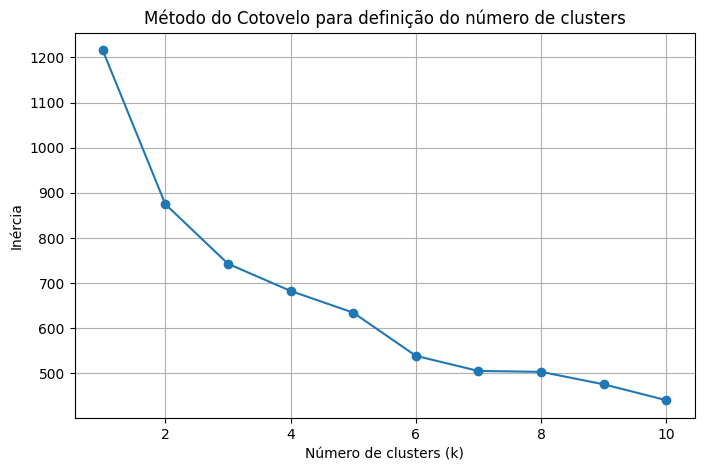

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Seleção das variáveis para clusterização
cols_cluster = [
    "pct_clientes_com_debito",
    "valor_medio_aberto_por_cliente_inadimplente",
    "pct_clientes_com_irregularidade",
    "economias_por_cliente",
    "consumo_medio_12m",
    "consumo_medio_24m",
    "pct_ligacao_agua_esgoto",
    "Quantidade de pessoas",
    "Total de domicílios",
    "Média de moradores em domicílios particulares ocupados",
    "Acesso a água",
    "Acesso a esgoto",
    "Lixo coletado_moradores",
    "Alfabetização 25 a 29",
    "Alfabetização 30 a 34",
    "Alfabetização 35 a 39"
]

X = df_final[cols_cluster]

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cálculo da inércia para diferentes números de clusters
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Gráfico do método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo para definição do número de clusters")
plt.grid(True)
plt.show()


O gráfico mostra que até quatro clusters há ganhos claros na separação dos perfis. A partir desse ponto, o ganho passa a ser marginal, indicando que aumentar o número de grupos não traria benefícios analíticos proporcionais. Por isso, adotamos quatro clusters.

In [94]:
# Aplicar KMeans com k = 4 e salvar cluster no df_final

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)

df_final["cluster"] = kmeans.fit_predict(X_scaled)

# Checar quantos setores em cada cluster
df_final["cluster"].value_counts().sort_index()

cluster
0    50
1    24
2     1
3     1
Name: count, dtype: int64

Inicialmente testamos quatro clusters, mas a distribuição resultou em grupos unitários, indicando a presença de outliers. Para obter perfis mais representativos e acionáveis, optamos por ajustar o modelo para três clusters.

In [95]:
# Aplicar KMeans com k = 3 e checar distribuição

from sklearn.cluster import KMeans

k = 3
kmeans_3 = KMeans(n_clusters=k, random_state=42)

df_final["cluster"] = kmeans_3.fit_predict(X_scaled)

df_final["cluster"].value_counts().sort_index()

cluster
0    50
1    24
2     2
Name: count, dtype: int64

A clusterização revelou dois grandes perfis territoriais e um pequeno conjunto de setores fora do padrão. Esses setores extremos foram mantidos no modelo justamente por representarem situações críticas que demandam atenção específica.

In [96]:
# Perfil médio dos clusters

# Seleção das variáveis usadas na clusterização
cluster_vars = [
    "pct_clientes_com_debito",
    "pct_clientes_com_irregularidade",
    "valor_medio_aberto_por_cliente_inadimplente",
    "economias_por_cliente",
    "consumo_medio_12m",
    "consumo_medio_24m",
    "pct_ligacao_agua_esgoto"
]

perfil_clusters = (
    df_final
    .groupby("cluster")[cluster_vars]
    .mean()
    .round(3)
)

perfil_clusters


,pct_clientes_com_debito,pct_clientes_com_irregularidade,valor_medio_aberto_por_cliente_inadimplente,economias_por_cliente,consumo_medio_12m,consumo_medio_24m,pct_ligacao_agua_esgoto
cluster,,,,,,,
0,0.715,0.196,4177.084,0.927,20.855,19.648,0.927
1,0.795,0.166,4468.581,1.069,19.280,19.240,0.915
2,0.598,0.161,10188.985,2.432,72.864,64.474,1.000


Os clusters 0 e 1 apresentam níveis semelhantes de inadimplência, mas diferem no perfil operacional: um concentra mais irregularidades e consumo, enquanto o outro apresenta inadimplência mais associada à capacidade de pagamento

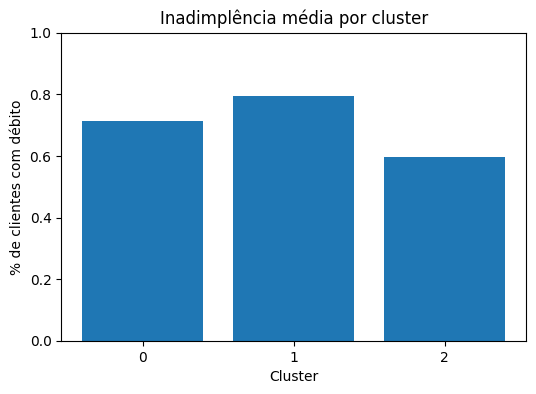

In [97]:
# Gráfico de barras — % de clientes com débito por cluster
plt.figure(figsize=(6,4))
plt.bar(
    perfil_clusters.index.astype(str),
    perfil_clusters["pct_clientes_com_debito"]
)

plt.ylabel("% de clientes com débito")
plt.xlabel("Cluster")
plt.title("Inadimplência média por cluster")

plt.ylim(0,1)
plt.show()


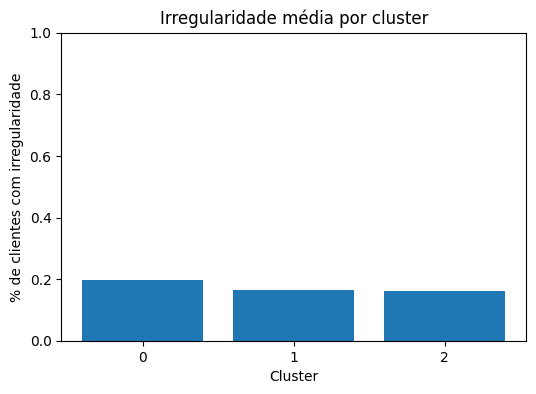

In [98]:
plt.figure(figsize=(6,4))
plt.bar(
    perfil_clusters.index.astype(str),
    perfil_clusters["pct_clientes_com_irregularidade"]
)

plt.ylabel("% de clientes com irregularidade")
plt.xlabel("Cluster")
plt.title("Irregularidade média por cluster")

plt.ylim(0,1)
plt.show()


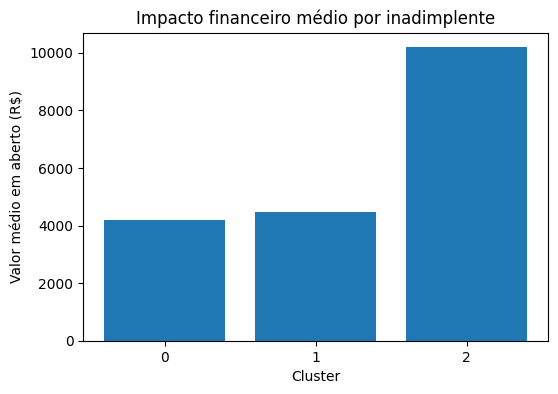

In [99]:
plt.figure(figsize=(6,4))
plt.bar(
    perfil_clusters.index.astype(str),
    perfil_clusters["valor_medio_aberto_por_cliente_inadimplente"]
)

plt.ylabel("Valor médio em aberto (R$)")
plt.xlabel("Cluster")
plt.title("Impacto financeiro médio por inadimplente")

plt.show()


Lembrando: O impacto financeiro médio é calculado como: valor total em aberto/ número de clientes inadimplentes. Clientes adimplentes não entram no denominador do impacto financeiro médio porque o objetivo do indicador é medir a severidade da inadimplência quando ela ocorre, e não diluir o valor pelo conjunto de clientes que não geram risco financeiro

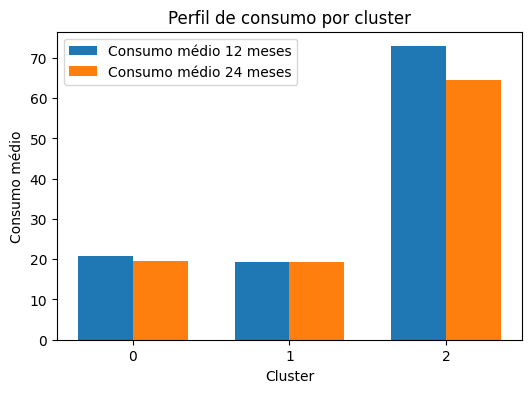

In [100]:
clusters = perfil_clusters.index.astype(str)
x = np.arange(len(clusters))  # posições no eixo X
width = 0.35                  # largura das barras

plt.figure(figsize=(6,4))

plt.bar(
    x - width/2,
    perfil_clusters["consumo_medio_12m"],
    width,
    label="Consumo médio 12 meses"
)

plt.bar(
    x + width/2,
    perfil_clusters["consumo_medio_24m"],
    width,
    label="Consumo médio 24 meses"
)

plt.ylabel("Consumo médio")
plt.xlabel("Cluster")
plt.title("Perfil de consumo por cluster")
plt.xticks(x, clusters)
plt.legend()

plt.show()


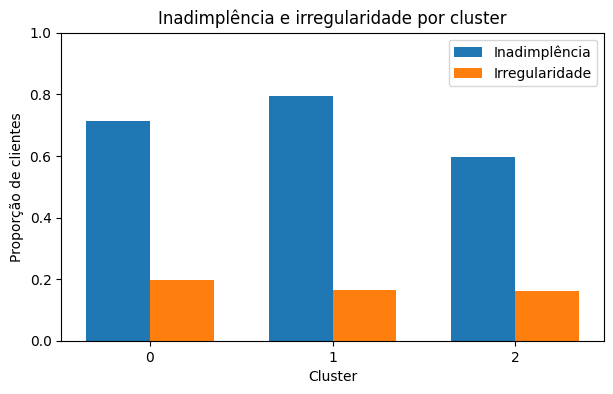

In [101]:
labels = perfil_clusters.index.astype(str)
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,4))

plt.bar(
    x - width/2,
    perfil_clusters["pct_clientes_com_debito"],
    width,
    label="Inadimplência"
)

plt.bar(
    x + width/2,
    perfil_clusters["pct_clientes_com_irregularidade"],
    width,
    label="Irregularidade"
)

plt.ylabel("Proporção de clientes")
plt.xlabel("Cluster")
plt.title("Inadimplência e irregularidade por cluster")
plt.xticks(x, labels)
plt.ylim(0,1)
plt.legend()

plt.show()


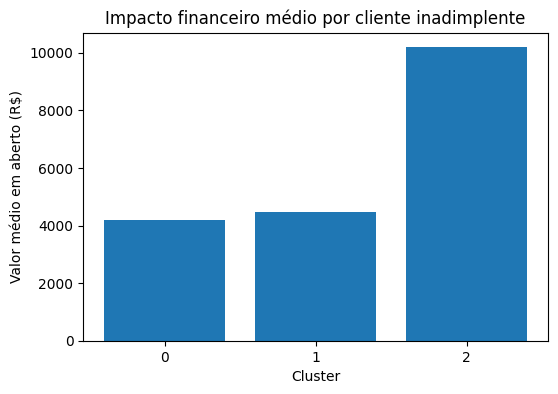

In [102]:
plt.figure(figsize=(6,4))

plt.bar(
    perfil_clusters.index.astype(str),
    perfil_clusters["valor_medio_aberto_por_cliente_inadimplente"]
)

plt.ylabel("Valor médio em aberto (R$)")
plt.xlabel("Cluster")
plt.title("Impacto financeiro médio por cliente inadimplente")

plt.show()


In [103]:
perfil_clusters.style.format({
    "pct_clientes_com_debito": "{:.1%}",
    "pct_clientes_com_irregularidade": "{:.1%}",
    "valor_medio_aberto_por_cliente_inadimplente": "R$ {:,.0f}",
    "consumo_medio_12m": "{:.1f}",
    "economias_por_cliente": "{:.2f}",
    "pct_ligacao_agua_esgoto": "{:.1%}"
}).background_gradient(cmap="Blues")


,pct_clientes_com_debito,pct_clientes_com_irregularidade,valor_medio_aberto_por_cliente_inadimplente,economias_por_cliente,consumo_medio_12m,consumo_medio_24m,pct_ligacao_agua_esgoto
cluster,,,,,,,
0,71.5%,19.6%,"R$ 4,177",0.93,20.9,19.648000,92.7%
1,79.5%,16.6%,"R$ 4,469",1.07,19.3,19.240000,91.5%
2,59.8%,16.1%,"R$ 10,189",2.43,72.9,64.474000,100.0%


### Cruzamento dos clusters com indicadores socioeconômicos (IBGE)

Objetivo:
Entender se os clusters criados a partir do comportamento de inadimplência,
consumo e relacionamento com a Sabesp também apresentam diferenças
socioeconômicas relevantes.

Nesta etapa, analisamos:
- Densidade domiciliar
- Acesso a serviços básicos (água, esgoto, coleta de lixo)
- Indicadores educacionais (alfabetização por faixa etária)

A análise é feita no nível de setor censitário (CD_SETOR), que é a unidade
territorial comum entre a base operacional e a base do IBGE.


#### Indicadores socioeconômicos selecionados

Os indicadores abaixo foram escolhidos porque ajudam a caracterizar:
- Condições de moradia
- Infraestrutura urbana
- Capital humano da população

Eles **não foram usados para criar os clusters**, apenas para interpretá-los.


In [108]:
df_final["densidade_domiciliar"] = (
    df_final["Total de domicílios particulares ocupados"] 
    / df_final["AREA_KM2"]
)


In [109]:
perfil_ibge_clusters = (
    df_final
    .groupby("cluster")[cols_ibge]
    .mean()
    .round(3)
)

perfil_ibge_clusters


,densidade_domiciliar,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
cluster,,,,,,,
0,24237.292,212.900,190.54,452.660,57.260,48.660,53.020
1,36414.516,436.667,382.00,953.375,114.042,105.917,105.333
2,43715.748,279.000,150.00,358.500,94.000,68.000,78.500


In [110]:
cols_heatmap = [
    "Acesso a água",
    "Acesso a esgoto",
    "Lixo coletado_moradores",
    "Alfabetização 25 a 29",
    "Alfabetização 30 a 34",
    "Alfabetização 35 a 39"
]

heatmap_data = perfil_ibge_clusters[cols_heatmap]
heatmap_data


,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
cluster,,,,,,
0,212.900,190.54,452.660,57.260,48.660,53.020
1,436.667,382.00,953.375,114.042,105.917,105.333
2,279.000,150.00,358.500,94.000,68.000,78.500


In [111]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()
heatmap_norm = pd.DataFrame(
    scaler.fit_transform(heatmap_data),
    index=heatmap_data.index,
    columns=heatmap_data.columns
)

heatmap_norm


,Acesso a água,Acesso a esgoto,Lixo coletado_moradores,Alfabetização 25 a 29,Alfabetização 30 a 34,Alfabetização 35 a 39
cluster,,,,,,
0,0.000000,0.174741,0.158285,0.000000,0.000000,0.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.295397,0.000000,0.000000,0.647036,0.337775,0.487068


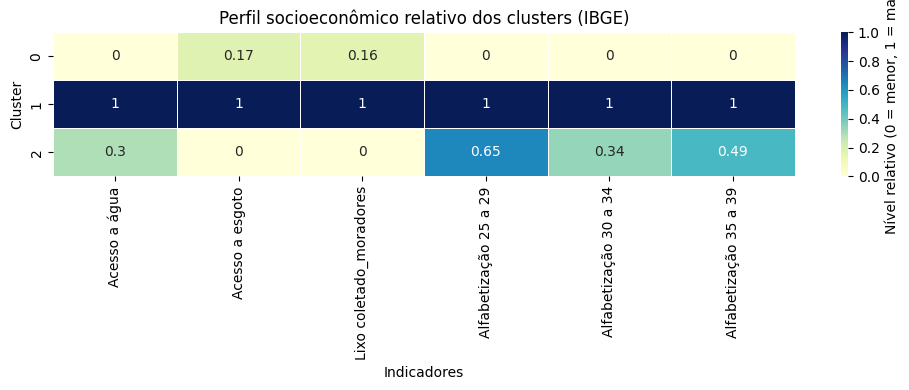

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))

sns.heatmap(
    heatmap_norm,
    annot=True,
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Nível relativo (0 = menor, 1 = maior)"}
)

plt.title("Perfil socioeconômico relativo dos clusters (IBGE)")
plt.xlabel("Indicadores")
plt.ylabel("Cluster")

plt.tight_layout()
plt.show()


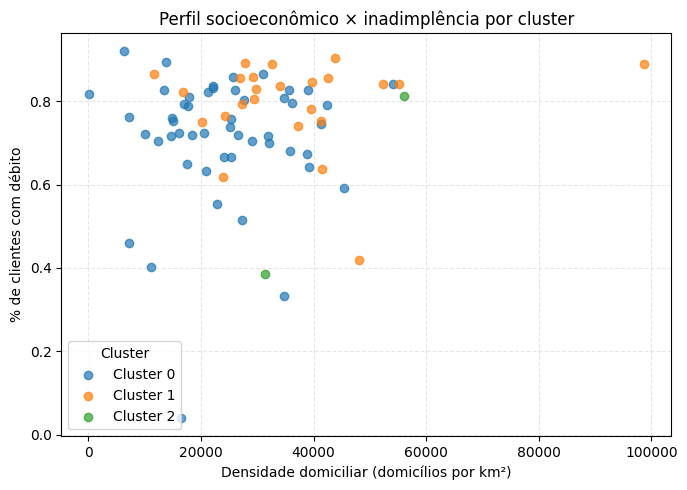

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for cluster in df_final["cluster"].unique():
    subset = df_final[df_final["cluster"] == cluster]
    plt.scatter(
        subset["densidade_domiciliar"],
        subset["pct_clientes_com_debito"],
        label=f"Cluster {cluster}",
        alpha=0.7
    )

plt.xlabel("Densidade domiciliar (domicílios por km²)")
plt.ylabel("% de clientes com débito")
plt.title("Perfil socioeconômico × inadimplência por cluster")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [121]:
import plotly
import nbformat

plotly.__version__


'6.5.1'

In [122]:
df_map_plot = df_map.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()

# Se você já tiver "perfil_interpretativo", ótimo.
# Se ainda não tiver, vamos criar um provisório como "Cluster X".
if "perfil_interpretativo" not in df_map_plot.columns:
    df_map_plot["perfil_interpretativo"] = df_map_plot["cluster"].astype(str).map(lambda x: f"Cluster {x}")

# Tamanho da bolha: escolha 1 variável
size_col = "valor_total_aberto"  # você pode trocar depois

# Garantir que size é numérico e sem negativos
df_map_plot[size_col] = pd.to_numeric(df_map_plot[size_col], errors="coerce").fillna(0)
df_map_plot = df_map_plot[df_map_plot[size_col] >= 0]

df_map_plot[[ "CD_SETOR", "LATITUDE", "LONGITUDE", "perfil_interpretativo", size_col ]].head()


,CD_SETOR,LATITUDE,LONGITUDE,perfil_interpretativo,valor_total_aberto
0,355030883000009,-23.619414,-46.726910,Cluster 0,264420.42
1,355030883000015,-23.615677,-46.720301,Cluster 0,340869.40
2,355030883000040,-23.612535,-46.725318,Cluster 0,729314.09
3,355030883000072,-23.617958,-46.723991,Cluster 0,336761.80
4,355030883000076,-23.618092,-46.725741,Cluster 0,63577.01


In [123]:
import plotly.express as px

# Paleta daltônico-friendly (Okabe-Ito)
okabe_ito = ["#0072B2", "#E69F00", "#009E73", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#000000"]

fig = px.scatter_map(
    df_map_plot,
    lat="LATITUDE",
    lon="LONGITUDE",
    color="perfil_interpretativo",
    size=size_col,
    size_max=35,
    zoom=14,
    height=650,
    hover_data={
        "CD_SETOR": True,
        "pct_clientes_com_debito": ":.1%",
        "pct_clientes_com_irregularidade": ":.1%",
        "valor_medio_aberto_por_cliente_inadimplente": ":.0f",
        size_col: ":.0f",
        "LATITUDE": False,
        "LONGITUDE": False
    },
    color_discrete_sequence=okabe_ito,
    title="Mapa territorial — Perfis (clusters) e impacto"
)

fig.update_layout(
    map_style="open-street-map",
    margin={"r":0,"t":50,"l":0,"b":0},
    legend_title_text="perfil_interpretativo"
)

fig.show()


In [124]:
df_final["cluster"].value_counts().sort_index()


cluster
0    50
1    24
2     2
Name: count, dtype: int64

In [131]:
print("Clusters:", df_final["cluster"].unique())
print("Qtd por cluster:")
print(df_final["cluster"].value_counts())
print("Setores:", df_final["CD_SETOR"].nunique())


Clusters: [0 1 2]
Qtd por cluster:
cluster
0    50
1    24
2     2
Name: count, dtype: int64
Setores: 76


In [130]:
df_final.to_excel("df_final.xlsx", index=False)
